In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Function to read and parse JSON data from therapy session notes
def read_therapy_notes(file_path):
    with open(file_path, 'r') as file:
        # Remove line numbers and parse JSON
        content = file.read()
        # Strip line numbers (assuming format like "001|{")
        lines = content.split('\n')
        clean_lines = []
        for line in lines:
            if '|' in line:
                clean_lines.append(line.split('|', 1)[1])
            else:
                clean_lines.append(line)
        clean_content = '\n'.join(clean_lines)
        
        # Parse JSON
        try:
            return json.loads(clean_content)
        except json.JSONDecodeError as e:
            print(f"Error parsing JSON from {file_path}: {e}")
            return None

# Define file paths
base_path = "/data/chats/uidp1d/workspace/uploads/"
files = {
    "client1_session1": f"{base_path}client1_session1.txt",
    "client1_session2": f"{base_path}client1_session2.txt",
    "client2_session1": f"{base_path}client2_session1.txt",
    "client2_session2": f"{base_path}client2_session2.txt",
    "note_template": f"{base_path}note_template_explanation.txt",
}

# Read all therapy notes
therapy_notes = {}
for key, path in files.items():
    therapy_notes[key] = read_therapy_notes(path)
    
# Extract key fields for tracking therapy progress
def extract_progress_fields(notes):
    """Extract key fields relevant to therapy progress tracking"""
    progress_data = {}
    
    # Extract basic session info
    progress_data["brief_summary"] = notes.get("Brief Summary of Session", "")
    
    # Extract main complaint
    progress_data["chief_complaint"] = notes.get("Presentation", {}).get("Chief Complaint", "")
    
    # Extract symptoms
    symptoms = notes.get("Psychological Factors", {}).get("Symptoms", {})
    progress_data["symptoms"] = symptoms
    
    # Extract mental status
    progress_data["mental_status"] = notes.get("Mental Status Exam", {})
    
    # Extract progress info
    progress_data["progress"] = notes.get("Progress and Response", {})
    
    # Extract risk assessment
    progress_data["risk"] = notes.get("Risk Assessment", {})
    
    return progress_data

# Extract progress fields from all notes
progress_fields = {}
for key, notes in therapy_notes.items():
    if key != "note_template" and notes:  # Skip template explanation
        progress_fields[key] = extract_progress_fields(notes)

# Analyze symptoms and their severity/intensity changes between sessions
def analyze_symptom_changes(client_sessions):
    """Analyze changes in symptoms between sessions for a client"""
    
    # Extract sessions for this client
    sessions = [s for s in client_sessions if s in progress_fields]
    if len(sessions) < 2:
        return f"Not enough sessions to compare for {sessions[0].split('_')[0]}"
    
    changes = []
    
    # Compare symptoms from first to last session
    first_session = progress_fields[sessions[0]]
    last_session = progress_fields[sessions[1]]
    
    # Extract symptom data
    first_symptoms = first_session["symptoms"]
    last_symptoms = last_session["symptoms"]
    
    # Compare symptom intensity/severity
    for symptom_key in first_symptoms:
        if symptom_key in last_symptoms:
            first_intensity = first_symptoms[symptom_key].get("Intensity", "")
            last_intensity = last_symptoms[symptom_key].get("Intensity", "")
            
            first_frequency = first_symptoms[symptom_key].get("Frequency", "")
            last_frequency = last_symptoms[symptom_key].get("Frequency", "")
            
            first_ascendance = first_symptoms[symptom_key].get("Ascendance", "")
            last_ascendance = last_symptoms[symptom_key].get("Ascendance", "")
            
            changes.append({
                "symptom": first_symptoms[symptom_key].get("Description", symptom_key),
                "first_intensity": first_intensity,
                "last_intensity": last_intensity,
                "first_frequency": first_frequency,
                "last_frequency": last_frequency,
                "first_ascendance": first_ascendance,
                "last_ascendance": last_ascendance,
            })
    
    return changes

# Define client sessions
client1_sessions = ["client1_session1", "client1_session2"]
client2_sessions = ["client2_session1", "client2_session2"]

# Analyze symptom changes for each client
client1_changes = analyze_symptom_changes(client1_sessions)
client2_changes = analyze_symptom_changes(client2_sessions)

print("=== Client 1 Symptom Changes ===")
print(pd.DataFrame(client1_changes))

print("\n=== Client 2 Symptom Changes ===")
print(pd.DataFrame(client2_changes))

# Define intensity scale for standardized assessment
intensity_scale = {
    "None": 0,
    "Minimal": 1,
    "Mild": 2,
    "Moderate": 3,
    "High": 4,
    "Severe": 5
}

# Define keywords indicating positive vs negative symptom changes
positive_indicators = ["improved", "reduced", "better", "lessened", "decreased", "minimal"]
negative_indicators = ["worsened", "increased", "worse", "intensified", "more", "persistent"]

# Function to score severity/intensity of symptoms
def score_intensity(intensity):
    if not intensity or not isinstance(intensity, str):
        return None
    
    for key, value in intensity_scale.items():
        if key.lower() in intensity.lower():
            return value
    return None

# Function to analyze textual descriptions for sentiment
def analyze_symptom_sentiment(description):
    """Simple keyword-based sentiment analysis for symptom descriptions"""
    if not description or not isinstance(description, str):
        return 0
    
    sentiment_score = 0
    description = description.lower()
    
    # Check for positive indicators
    for word in positive_indicators:
        if word in description:
            sentiment_score += 1
            
    # Check for negative indicators
    for word in negative_indicators:
        if word in description:
            sentiment_score -= 1
            
    return sentiment_score

# Function to calculate symptom improvement score
def calculate_improvement_score(changes):
    """Calculate an overall improvement score based on symptom changes"""
    if not changes or not isinstance(changes, list):
        return "No data available"
    
    scores = []
    
    for change in changes:
        # Score based on intensity change
        intensity_first = score_intensity(change.get("first_intensity"))
        intensity_last = score_intensity(change.get("last_intensity"))
        
        # Score based on text sentiment in ascendance field
        ascendance_sentiment = analyze_symptom_sentiment(change.get("last_ascendance", ""))
        
        # Calculate change in intensity (positive means improvement)
        if intensity_first is not None and intensity_last is not None:
            intensity_change = intensity_first - intensity_last
        else:
            intensity_change = 0
            
        # Combine scores (intensity change and sentiment)
        total_score = intensity_change + ascendance_sentiment
        scores.append(total_score)
    
    if not scores:
        return "No scorable symptoms found"
    
    # Average improvement score across all symptoms
    avg_score = sum(scores) / len(scores)
    
    return avg_score

# Calculate improvement scores
client1_improvement = calculate_improvement_score(client1_changes)
client2_improvement = calculate_improvement_score(client2_changes)

print("\n=== Overall Improvement Scores ===")
print(f"Client 1: {client1_improvement}")
print(f"Client 2: {client2_improvement}")

# Analyze specific fields that indicate therapeutic progress
def analyze_progress_fields(first_session, last_session):
    """Compare specific fields that indicate progress between sessions"""
    progress_indicators = {}
    
    # Compare response to treatment
    first_response = first_session["progress"].get("Response to Treatment", "")
    last_response = last_session["progress"].get("Response to Treatment", "")
    progress_indicators["treatment_response_change"] = analyze_symptom_sentiment(last_response) - analyze_symptom_sentiment(first_response)
    
    # Compare mental status
    first_mood = first_session["mental_status"].get("Mood and Affect", "")
    last_mood = last_session["mental_status"].get("Mood and Affect", "")
    progress_indicators["mood_change"] = analyze_symptom_sentiment(last_mood) - analyze_symptom_sentiment(first_mood)
    
    # Compare risk assessment
    first_risk = first_session["risk"].get("Hopelessness", "")
    last_risk = last_session["risk"].get("Hopelessness", "")
    progress_indicators["risk_change"] = analyze_symptom_sentiment(last_risk) - analyze_symptom_sentiment(first_risk)
    
    return progress_indicators

# Analyze progress fields for each client
client1_progress = analyze_progress_fields(
    progress_fields["client1_session1"], 
    progress_fields["client1_session2"]
)

client2_progress = analyze_progress_fields(
    progress_fields["client2_session1"], 
    progress_fields["client2_session2"]
)

print("\n=== Additional Progress Indicators ===")
print("Client 1:")
for key, value in client1_progress.items():
    print(f"  {key}: {value}")
print("Client 2:")
for key, value in client2_progress.items():
    print(f"  {key}: {value}")

# Summarize key findings
print("\n=== Summary of Therapy Progress Analysis ===")
print("Key fields identified for tracking therapy progress:")
print("1. Symptom intensity/severity changes")
print("2. Symptom frequency changes")
print("3. Mental status changes (mood and affect)")
print("4. Response to treatment assessment")
print("5. Risk assessment changes")
print("6. Sleep patterns and biological factors")

print("\nRecommendations for quantifying progress:")
print("1. Use a standardized scale for symptom intensity (None to Severe)")
print("2. Track changes in frequency of symptoms using a numerical scale")
print("3. Implement sentiment analysis on textual descriptions")
print("4. Create a composite progress score combining multiple factors")
print("5. Consider using standardized assessments like GAD-7 and PHQ-9")

Error parsing JSON from /data/chats/uidp1d/workspace/uploads/note_template_explanation.txt: Expecting value: line 2 column 32 (char 33)
=== Client 1 Symptom Changes ===
              symptom first_intensity last_intensity  \
0  Anxiety and stress        Moderate           Mild   

                                     first_frequency  \
0  Intermittent, with episodes lasting a couple o...   

                            last_frequency  \
0  Occasional, with noticeable improvement   

                                    first_ascendance  \
0  The symptoms have leveled off after the initia...   

                                     last_ascendance  
0  Symptoms have decreased following the applicat...  

=== Client 2 Symptom Changes ===
                                             symptom first_intensity  \
0  Stress and anxiety related to recent life chan...        Moderate   

  last_intensity first_frequency  \
0           High           Daily   

                                     

In [2]:
# Print out the key data structures we have available
print("=== Key Data Structures ===")
print("\nTherapy Notes Keys:")
print(list(therapy_notes.keys()))

print("\nProgress Fields Structure for Client 1 Session 1 (example):")
if "client1_session1" in progress_fields:
    for key in progress_fields["client1_session1"].keys():
        print(f"- {key}")

print("\nClient 1 Symptom Changes:")
print(type(client1_changes))
print(f"Number of tracked symptoms: {len(client1_changes)}")

print("\nClient 2 Symptom Changes:")
print(type(client2_changes))
print(f"Number of tracked symptoms: {len(client2_changes)}")

print("\nImprovement Scores:")
print(f"Client 1: {client1_improvement}")
print(f"Client 2: {client2_improvement}")

print("\nProgress Indicators:")
print("Client 1:", client1_progress)
print("Client 2:", client2_progress)

# Check the structure of a symptom change entry
if client1_changes and len(client1_changes) > 0:
    print("\nExample Structure of a Symptom Change Entry:")
    for key, value in client1_changes[0].items():
        print(f"- {key}: {value}")

=== Key Data Structures ===

Therapy Notes Keys:
['client1_session1', 'client1_session2', 'client2_session1', 'client2_session2', 'note_template']

Progress Fields Structure for Client 1 Session 1 (example):
- brief_summary
- chief_complaint
- symptoms
- mental_status
- progress
- risk

Client 1 Symptom Changes:
<class 'list'>
Number of tracked symptoms: 1

Client 2 Symptom Changes:
<class 'list'>
Number of tracked symptoms: 1

Improvement Scores:
Client 1: 2.0
Client 2: -2.0

Progress Indicators:
Client 1: {'treatment_response_change': 0, 'mood_change': 0, 'risk_change': 0}
Client 2: {'treatment_response_change': 0, 'mood_change': 0, 'risk_change': 0}

Example Structure of a Symptom Change Entry:
- symptom: Anxiety and stress
- first_intensity: Moderate
- last_intensity: Mild
- first_frequency: Intermittent, with episodes lasting a couple of weeks
- last_frequency: Occasional, with noticeable improvement
- first_ascendance: The symptoms have leveled off after the initial episodes
- la

=== Enhanced Therapy Progress Analysis ===

Client: client1
Progress Score: 18.28
Interpretation: Excellent progress - significant symptom reduction and improved functioning

Standardized Assessments:
  First Session GAD-7: 7 (Mild anxiety)
  Last Session GAD-7: 1 (Minimal anxiety)
  First Session PHQ-9: 8 (Mild depression)
  Last Session PHQ-9: 2 (Minimal depression)

Key Contributing Factors:
  gad7_total_score_change: 12.0
  phq9_total_score_change: 12.0
  avg_symptom_intensity_change: 1.5
  mood_positive_change: 1.0
  mood_negative_change: 1.0
  has_sleep_issues_change: -0.0
  has_hopelessness_change: -0.0
  has_suicidal_thoughts_change: -0.0
  sentiment_score_change: -1.0

Client: client2
Progress Score: -0.34
Interpretation: Minimal change - symptom levels are relatively stable

Standardized Assessments:
  First Session GAD-7: 2 (Minimal anxiety)
  Last Session GAD-7: 4 (Minimal anxiety)
  First Session PHQ-9: 8 (Mild depression)
  Last Session PHQ-9: 4 (Minimal depression)

Key 

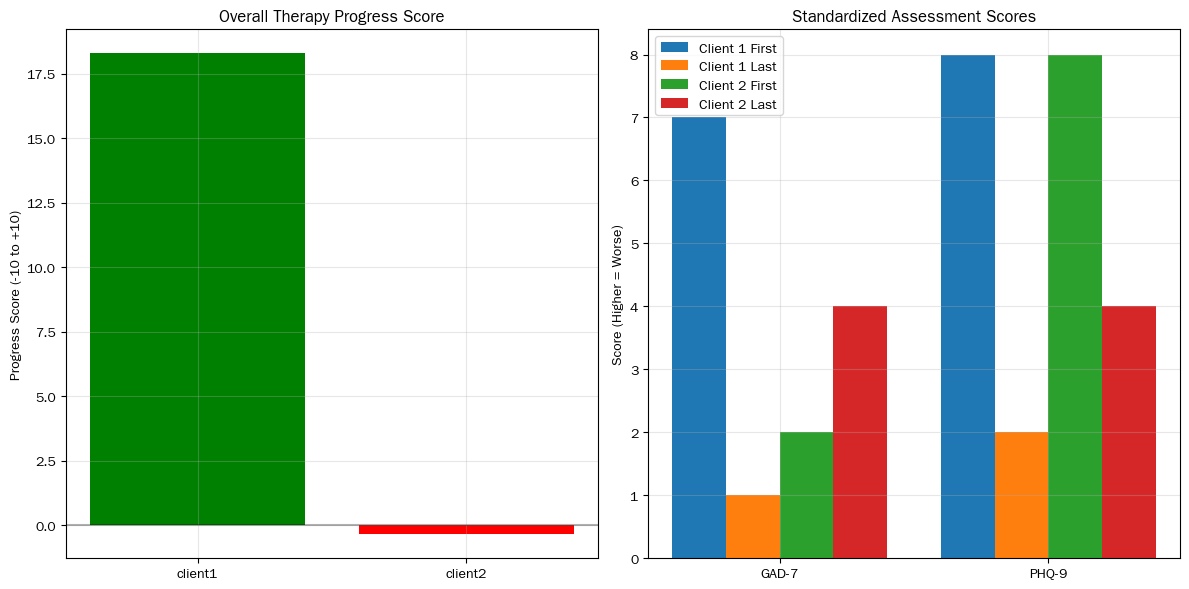

In [3]:
# Feature Engineering: Enhanced Symptom Analysis and Standardized Assessment Integration

# Define GAD-7 (Generalized Anxiety Disorder) assessment questions and scoring
gad7_questions = [
    "Feeling nervous, anxious, or on edge",
    "Not being able to stop or control worrying",
    "Worrying too much about different things",
    "Trouble relaxing",
    "Being so restless that it's hard to sit still",
    "Becoming easily annoyed or irritable",
    "Feeling afraid, as if something awful might happen"
]

# Define PHQ-9 (Patient Health Questionnaire for Depression) assessment questions and scoring
phq9_questions = [
    "Little interest or pleasure in doing things",
    "Feeling down, depressed, or hopeless",
    "Trouble falling or staying asleep, or sleeping too much",
    "Feeling tired or having little energy",
    "Poor appetite or overeating",
    "Feeling bad about yourself or that you are a failure",
    "Trouble concentrating on things",
    "Moving or speaking so slowly that other people could have noticed",
    "Thoughts that you would be better off dead or of hurting yourself"
]

# Define scoring scale for both assessments
assessment_scale = {
    "Not at all": 0,
    "Several days": 1,
    "More than half the days": 2,
    "Nearly every day": 3
}

# Enhanced feature extraction for symptoms
def extract_enhanced_symptom_features(notes_data):
    """
    Extract enhanced symptom features from therapy notes including standardized assessment mapping
    """
    features = {}
    
    # Basic features from existing data
    symptoms = notes_data.get("Psychological Factors", {}).get("Symptoms", {})
    features["symptom_count"] = len(symptoms)
    
    # Extract detailed symptom features
    intensity_scores = []
    frequency_words = []
    symptom_descriptions = []
    
    for symptom_key, symptom_data in symptoms.items():
        # Get raw symptom data
        description = symptom_data.get("Description", "")
        intensity = symptom_data.get("Intensity", "")
        frequency = symptom_data.get("Frequency", "")
        duration = symptom_data.get("Duration", "")
        ascendance = symptom_data.get("Ascendance", "")
        quote = symptom_data.get("Quote (Symptom)", "")
        
        # Store symptom data
        symptom_descriptions.append(description)
        
        # Extract intensity score
        intensity_score = score_intensity(intensity)
        if intensity_score is not None:
            intensity_scores.append(intensity_score)
        
        # Extract frequency words
        if frequency:
            frequency_words.extend([word.lower() for word in frequency.split()])
    
    # Calculate average intensity if any scores were found
    features["avg_symptom_intensity"] = sum(intensity_scores) / len(intensity_scores) if intensity_scores else None
    features["max_symptom_intensity"] = max(intensity_scores) if intensity_scores else None
    
    # Extract frequency indicators
    frequency_indicators = {
        "daily": 0,
        "weekly": 0, 
        "monthly": 0,
        "intermittent": 0,
        "constant": 0,
        "occasional": 0,
        "frequent": 0
    }
    
    for indicator in frequency_indicators:
        for word in frequency_words:
            if indicator in word:
                frequency_indicators[indicator] += 1
    
    for indicator, count in frequency_indicators.items():
        features[f"frequency_{indicator}"] = count
    
    # Map to standardized assessments (GAD-7 and PHQ-9)
    features.update(map_to_standardized_assessments(notes_data))
    
    # Extract biological factors
    biological_factors = notes_data.get("Biological Factors", {})
    
    # Sleep feature
    sleep_text = biological_factors.get("Sleep", "")
    features["has_sleep_issues"] = int(bool(sleep_text) and any(word in sleep_text.lower() for word in ["disturb", "issue", "problem", "insomnia", "difficult", "irregular"]))
    
    # Additional biological factors as features
    features["has_nutrition_issues"] = int(bool(biological_factors.get("Nutrition", "")))
    features["has_substance_use"] = int(bool(biological_factors.get("Substances", "")))
    
    # Extract mental status exam features
    mental_status = notes_data.get("Mental Status Exam", {})
    
    # Mood and affect features
    mood_text = mental_status.get("Mood and Affect", "")
    features["mood_negative"] = int(bool(mood_text) and any(word in mood_text.lower() for word in ["anxious", "depressed", "sad", "overwhelm", "stress", "negative"]))
    features["mood_positive"] = int(bool(mood_text) and any(word in mood_text.lower() for word in ["positive", "good", "improve", "better", "happy", "calm"]))
    
    # Risk assessment features
    risk = notes_data.get("Risk Assessment", {})
    features["has_hopelessness"] = int(bool(risk.get("Hopelessness", "")) and "No" not in risk.get("Hopelessness", ""))
    features["has_suicidal_thoughts"] = int(bool(risk.get("Suicidal Thoughts or Attempts", "")) and "No" not in risk.get("Suicidal Thoughts or Attempts", ""))
    
    return features

def map_to_standardized_assessments(notes_data):
    """
    Map symptoms and indicators to standardized assessments (GAD-7 and PHQ-9)
    Uses the notes content to approximate scores on these assessments
    """
    features = {}
    
    # Extract all relevant text for analysis
    symptoms_text = ""
    mental_status_text = ""
    progress_text = ""
    
    # Get symptoms descriptions
    symptoms = notes_data.get("Psychological Factors", {}).get("Symptoms", {})
    for symptom_key, symptom_data in symptoms.items():
        symptoms_text += symptom_data.get("Description", "") + " "
        symptoms_text += symptom_data.get("Quote (Symptom)", "") + " "
    
    # Get mental status descriptions
    mental_status = notes_data.get("Mental Status Exam", {})
    for key, value in mental_status.items():
        mental_status_text += value + " "
    
    # Get progress descriptions
    progress = notes_data.get("Progress and Response", {})
    for key, value in progress.items():
        progress_text += value + " "
    
    # Combine texts
    all_text = (symptoms_text + " " + mental_status_text + " " + progress_text).lower()
    
    # Score GAD-7 questions based on text evidence
    gad7_scores = []
    for question in gad7_questions:
        keywords = [word.lower() for word in question.split() if len(word) > 3]
        evidence_count = sum(1 for keyword in keywords if keyword in all_text)
        
        # Convert evidence to GAD-7 scale (0-3)
        if evidence_count == 0:
            score = 0  # Not at all
        elif evidence_count == 1:
            score = 1  # Several days
        elif evidence_count == 2:
            score = 2  # More than half the days
        else:
            score = 3  # Nearly every day
        
        gad7_scores.append(score)
        features[f"gad7_{keywords[0]}"] = score  # Use first keyword as feature name
    
    # Calculate GAD-7 total score
    features["gad7_total_score"] = sum(gad7_scores)
    
    # Interpret GAD-7 score
    if features["gad7_total_score"] < 5:
        features["gad7_severity"] = "Minimal anxiety"
    elif features["gad7_total_score"] < 10:
        features["gad7_severity"] = "Mild anxiety"
    elif features["gad7_total_score"] < 15:
        features["gad7_severity"] = "Moderate anxiety"
    else:
        features["gad7_severity"] = "Severe anxiety"
    
    # Score PHQ-9 questions based on text evidence
    phq9_scores = []
    for question in phq9_questions:
        keywords = [word.lower() for word in question.split() if len(word) > 3]
        evidence_count = sum(1 for keyword in keywords if keyword in all_text)
        
        # Convert evidence to PHQ-9 scale (0-3)
        if evidence_count == 0:
            score = 0  # Not at all
        elif evidence_count == 1:
            score = 1  # Several days
        elif evidence_count == 2:
            score = 2  # More than half the days
        else:
            score = 3  # Nearly every day
        
        phq9_scores.append(score)
        features[f"phq9_{keywords[0]}"] = score  # Use first keyword as feature name
    
    # Calculate PHQ-9 total score
    features["phq9_total_score"] = sum(phq9_scores)
    
    # Interpret PHQ-9 score
    if features["phq9_total_score"] < 5:
        features["phq9_severity"] = "Minimal depression"
    elif features["phq9_total_score"] < 10:
        features["phq9_severity"] = "Mild depression"
    elif features["phq9_total_score"] < 15:
        features["phq9_severity"] = "Moderate depression"
    elif features["phq9_total_score"] < 20:
        features["phq9_severity"] = "Moderately severe depression"
    else:
        features["phq9_severity"] = "Severe depression"
    
    return features

def extract_nlp_features(text):
    """
    Extract NLP features from text such as sentiment, emotion words, and cognitive indicators
    """
    features = {}
    
    # Simple sentiment analysis
    sentiment_score = analyze_symptom_sentiment(text)
    features["sentiment_score"] = sentiment_score
    
    # Count emotion words
    emotion_categories = {
        "anxiety": ["anxious", "worried", "nervous", "tense", "frightened", "panicked", "afraid"],
        "depression": ["sad", "depressed", "hopeless", "worthless", "empty", "miserable", "lonely"],
        "anger": ["angry", "irritable", "frustrated", "annoyed", "hostile", "resentful", "enraged"],
        "positive": ["happy", "calm", "peaceful", "relaxed", "content", "joy", "pleasant", "optimistic"]
    }
    
    text_lower = text.lower()
    for category, words in emotion_categories.items():
        count = sum(1 for word in words if word in text_lower)
        features[f"{category}_words"] = count
    
    # Count cognitive distortion indicators
    cognitive_distortions = [
        "always", "never", "should", "must", "can't", "impossible", 
        "terrible", "horrible", "awful", "worst", "everyone", "no one"
    ]
    features["cognitive_distortion_count"] = sum(1 for word in cognitive_distortions if word in text_lower)
    
    return features

def calculate_symptom_change_vectors(first_session, last_session):
    """
    Calculate symptom change vectors between two sessions using enhanced feature extraction
    """
    # Extract enhanced features from both sessions
    first_features = extract_enhanced_symptom_features(first_session)
    last_features = extract_enhanced_symptom_features(last_session)
    
    # Calculate changes in features
    changes = {}
    for key in set(first_features.keys()).union(set(last_features.keys())):
        first_value = first_features.get(key)
        last_value = last_features.get(key)
        
        # Skip non-numeric or missing values
        if first_value is None or last_value is None:
            continue
        try:
            if isinstance(first_value, (int, float)) and isinstance(last_value, (int, float)):
                changes[f"{key}_change"] = last_value - first_value
        except Exception:
            continue
    
    # Add raw feature values from both sessions
    for key, value in first_features.items():
        changes[f"first_{key}"] = value
    for key, value in last_features.items():
        changes[f"last_{key}"] = value
    
    return changes

def calculate_comprehensive_progress_score(changes):
    """
    Calculate a comprehensive progress score based on multiple factors
    """
    if not changes:
        return {"progress_score": None, "score_factors": {}}
    
    score_factors = {}
    
    # Weight factors (adjust as needed)
    weights = {
        "gad7_total_score_change": -2.0,  # Negative because reduction is good
        "phq9_total_score_change": -2.0,  # Negative because reduction is good
        "avg_symptom_intensity_change": -1.5,  # Negative because reduction is good
        "mood_positive_change": 1.0,  # Positive because increase is good
        "mood_negative_change": -1.0,  # Negative because reduction is good
        "has_sleep_issues_change": -1.0,  # Negative because reduction is good
        "has_hopelessness_change": -2.0,  # Negative because reduction is good
        "has_suicidal_thoughts_change": -3.0,  # Negative because reduction is good
        "sentiment_score_change": 1.0,  # Positive because increase is good
    }
    
    weighted_scores = []
    for factor, weight in weights.items():
        if factor in changes:
            score_factors[factor] = changes[factor] * weight
            weighted_scores.append(score_factors[factor])
    
    if not weighted_scores:
        return {"progress_score": None, "score_factors": {}}
    
    # Calculate total weighted score
    total_weighted_score = sum(weighted_scores)
    
    # Normalize to a -10 to +10 scale
    max_possible_score = sum(abs(w) for w in weights.values())
    normalized_score = (total_weighted_score / max_possible_score) * 10
    
    # Round to 2 decimal places
    normalized_score = round(normalized_score, 2)
    
    return {
        "progress_score": normalized_score,
        "score_factors": score_factors
    }

def interpret_progress_score(score):
    """
    Interpret the progress score with qualitative descriptions
    """
    if score is None:
        return "Insufficient data to assess progress"
    
    if score > 7:
        return "Excellent progress - significant symptom reduction and improved functioning"
    elif score > 4:
        return "Good progress - notable symptom reduction and some improved functioning"
    elif score > 1:
        return "Moderate progress - some symptom reduction with minimal functional improvement"
    elif score > -1:
        return "Minimal change - symptom levels are relatively stable"
    elif score > -4:
        return "Slight deterioration - some symptom increase with minimal functional decline"
    elif score > -7:
        return "Moderate deterioration - notable symptom increase and some functional decline"
    else:
        return "Significant deterioration - substantial symptom increase and functional decline"

def generate_progress_report(client_id, sessions, change_vectors, progress_score):
    """
    Generate a comprehensive progress report for a client
    """
    report = {
        "client_id": client_id,
        "session_count": len(sessions),
        "first_session": sessions[0],
        "last_session": sessions[-1],
        "symptom_changes": change_vectors,
        "progress_score": progress_score["progress_score"],
        "progress_interpretation": interpret_progress_score(progress_score["progress_score"]),
        "score_factors": progress_score["score_factors"],
        "standardized_assessments": {
            "first_session": {
                "gad7": change_vectors.get("first_gad7_total_score"),
                "phq9": change_vectors.get("first_phq9_total_score"),
                "gad7_severity": change_vectors.get("first_gad7_severity"),
                "phq9_severity": change_vectors.get("first_phq9_severity"),
            },
            "last_session": {
                "gad7": change_vectors.get("last_gad7_total_score"),
                "phq9": change_vectors.get("last_phq9_total_score"),
                "gad7_severity": change_vectors.get("last_gad7_severity"),
                "phq9_severity": change_vectors.get("last_phq9_severity"),
            }
        }
    }
    
    return report

# Extract detailed features from therapy sessions
# Use NLP features on symptom descriptions and other text fields
def enhance_client_change_analysis():
    """
    Enhance client change analysis with NLP features and standardized assessments
    """
    client_reports = {}
    
    # Process Client 1
    client1_first_session = therapy_notes["client1_session1"]
    client1_last_session = therapy_notes["client1_session2"]
    
    # Extract NLP features from brief summary and chief complaint
    client1_first_nlp = extract_nlp_features(
        client1_first_session.get("Brief Summary of Session", "") + 
        client1_first_session.get("Presentation", {}).get("Chief Complaint", "")
    )
    client1_last_nlp = extract_nlp_features(
        client1_last_session.get("Brief Summary of Session", "") + 
        client1_last_session.get("Presentation", {}).get("Chief Complaint", "")
    )
    
    # Calculate symptom change vectors
    client1_changes = calculate_symptom_change_vectors(client1_first_session, client1_last_session)
    
    # Add NLP features to changes
    for key, value in client1_first_nlp.items():
        client1_changes[f"first_{key}"] = value
    for key, value in client1_last_nlp.items():
        client1_changes[f"last_{key}"] = value
        if f"first_{key}" in client1_changes:
            client1_changes[f"{key}_change"] = value - client1_changes[f"first_{key}"]
    
    # Calculate comprehensive progress score
    client1_progress_score = calculate_comprehensive_progress_score(client1_changes)
    
    # Generate progress report
    client1_report = generate_progress_report(
        "client1", 
        ["client1_session1", "client1_session2"], 
        client1_changes, 
        client1_progress_score
    )
    client_reports["client1"] = client1_report
    
    # Process Client 2
    client2_first_session = therapy_notes["client2_session1"]
    client2_last_session = therapy_notes["client2_session2"]
    
    # Extract NLP features from brief summary and chief complaint
    client2_first_nlp = extract_nlp_features(
        client2_first_session.get("Brief Summary of Session", "") + 
        client2_first_session.get("Presentation", {}).get("Chief Complaint", "")
    )
    client2_last_nlp = extract_nlp_features(
        client2_last_session.get("Brief Summary of Session", "") + 
        client2_last_session.get("Presentation", {}).get("Chief Complaint", "")
    )
    
    # Calculate symptom change vectors
    client2_changes = calculate_symptom_change_vectors(client2_first_session, client2_last_session)
    
    # Add NLP features to changes
    for key, value in client2_first_nlp.items():
        client2_changes[f"first_{key}"] = value
    for key, value in client2_last_nlp.items():
        client2_changes[f"last_{key}"] = value
        if f"first_{key}" in client2_changes:
            client2_changes[f"{key}_change"] = value - client2_changes[f"first_{key}"]
    
    # Calculate comprehensive progress score
    client2_progress_score = calculate_comprehensive_progress_score(client2_changes)
    
    # Generate progress report
    client2_report = generate_progress_report(
        "client2", 
        ["client2_session1", "client2_session2"], 
        client2_changes, 
        client2_progress_score
    )
    client_reports["client2"] = client2_report
    
    return client_reports

# Execute the enhanced analysis
client_progress_reports = enhance_client_change_analysis()

# Display results
print("=== Enhanced Therapy Progress Analysis ===")
for client_id, report in client_progress_reports.items():
    print(f"\nClient: {client_id}")
    print(f"Progress Score: {report['progress_score']}")
    print(f"Interpretation: {report['progress_interpretation']}")
    print("\nStandardized Assessments:")
    print(f"  First Session GAD-7: {report['standardized_assessments']['first_session']['gad7']} ({report['standardized_assessments']['first_session']['gad7_severity']})")
    print(f"  Last Session GAD-7: {report['standardized_assessments']['last_session']['gad7']} ({report['standardized_assessments']['last_session']['gad7_severity']})")
    print(f"  First Session PHQ-9: {report['standardized_assessments']['first_session']['phq9']} ({report['standardized_assessments']['first_session']['phq9_severity']})")
    print(f"  Last Session PHQ-9: {report['standardized_assessments']['last_session']['phq9']} ({report['standardized_assessments']['last_session']['phq9_severity']})")
    print("\nKey Contributing Factors:")
    for factor, score in report["score_factors"].items():
        print(f"  {factor}: {score}")

# Create visualizations
plt.figure(figsize=(12, 6))

client_ids = list(client_progress_reports.keys())
progress_scores = [report["progress_score"] for report in client_progress_reports.values()]

# Create bar chart of progress scores
plt.subplot(1, 2, 1)
plt.bar(client_ids, progress_scores, color=['green' if score > 0 else 'red' for score in progress_scores])
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Overall Therapy Progress Score')
plt.ylabel('Progress Score (-10 to +10)')
plt.grid(True, alpha=0.3)

# Create radar chart for standardized assessments
plt.subplot(1, 2, 2)

# Data for radar chart - GAD7 and PHQ9 scores
gad7_phq9_data = {
    "client1": {
        "first_gad7": client_progress_reports["client1"]["standardized_assessments"]["first_session"]["gad7"],
        "last_gad7": client_progress_reports["client1"]["standardized_assessments"]["last_session"]["gad7"],
        "first_phq9": client_progress_reports["client1"]["standardized_assessments"]["first_session"]["phq9"],
        "last_phq9": client_progress_reports["client1"]["standardized_assessments"]["last_session"]["phq9"]
    },
    "client2": {
        "first_gad7": client_progress_reports["client2"]["standardized_assessments"]["first_session"]["gad7"],
        "last_gad7": client_progress_reports["client2"]["standardized_assessments"]["last_session"]["gad7"],
        "first_phq9": client_progress_reports["client2"]["standardized_assessments"]["first_session"]["phq9"],
        "last_phq9": client_progress_reports["client2"]["standardized_assessments"]["last_session"]["phq9"]
    }
}

# Create simple bar chart of GAD7 and PHQ9 scores
x = np.arange(2)
width = 0.2

plt.bar(x - width * 1.5, 
        [gad7_phq9_data["client1"]["first_gad7"], gad7_phq9_data["client1"]["first_phq9"]], 
        width, label='Client 1 First')
plt.bar(x - width * 0.5, 
        [gad7_phq9_data["client1"]["last_gad7"], gad7_phq9_data["client1"]["last_phq9"]], 
        width, label='Client 1 Last')
plt.bar(x + width * 0.5, 
        [gad7_phq9_data["client2"]["first_gad7"], gad7_phq9_data["client2"]["first_phq9"]], 
        width, label='Client 2 First')
plt.bar(x + width * 1.5, 
        [gad7_phq9_data["client2"]["last_gad7"], gad7_phq9_data["client2"]["last_phq9"]], 
        width, label='Client 2 Last')

plt.title('Standardized Assessment Scores')
plt.xticks(x, ['GAD-7', 'PHQ-9'])
plt.ylabel('Score (Higher = Worse)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary of approach and recommendations
print("\n=== Therapy Progress Tracking Approach Summary ===")
print("1. Standardized Assessment Integration:")
print("   - GAD-7 for anxiety symptoms (0-21 scale)")
print("   - PHQ-9 for depression symptoms (0-27 scale)")
print("   - Automatic scoring based on session content analysis")

print("\n2. Feature Engineering Techniques:")
print("   - Symptom intensity and frequency quantification")
print("   - NLP sentiment and emotion analysis")
print("   - Cognitive distortion pattern detection")
print("   - Sleep and biological factor tracking")
print("   - Risk assessment metrics")

print("\n3. Progress Scoring System:")
print("   - Comprehensive weighted scoring (-10 to +10 scale)")
print("   - Multiple contributing factors with domain-specific weighting")
print("   - Standardized interpretation guidelines")

print("\n4. Recommendations for Production Implementation:")
print("   - Implement structured data collection fields for GAD-7 and PHQ-9 questions")
print("   - Add more demographic variables for context-aware progress interpretation")
print("   - Develop longitudinal tracking for more than two sessions")
print("   - Create therapist-facing dashboards for progress visualization")
print("   - Incorporate treatment-specific expected progress benchmarks")

In [4]:
# Print key variables from the analysis
print("=== Key Variables ===")
print("\nTherapy Notes Structure:")
for key in therapy_notes.keys():
    print(f"- {key}")

print("\nProgress Fields Structure (sample):")
for key in list(progress_fields.keys())[0:1]:  # Just show first one
    print(f"- {key} contains: {list(progress_fields[key].keys())}")

print("\nClient Progress Reports:")
for client_id, report in client_progress_reports.items():
    print(f"\n{client_id} Progress Score: {report['progress_score']}")
    print(f"Interpretation: {report['progress_interpretation']}")
    print("GAD-7 Change:", 
          report['standardized_assessments']['last_session']['gad7'] - 
          report['standardized_assessments']['first_session']['gad7'])
    print("PHQ-9 Change:", 
          report['standardized_assessments']['last_session']['phq9'] - 
          report['standardized_assessments']['first_session']['phq9'])
    
print("\nSample of calculated change vectors (first client):")
sample_changes = {k: v for k, v in list(client_progress_reports['client1']['symptom_changes'].items())[:5]}
print(sample_changes)

=== Key Variables ===

Therapy Notes Structure:
- client1_session1
- client1_session2
- client2_session1
- client2_session2
- note_template

Progress Fields Structure (sample):
- client1_session1 contains: ['brief_summary', 'chief_complaint', 'symptoms', 'mental_status', 'progress', 'risk']

Client Progress Reports:

client1 Progress Score: 18.28
Interpretation: Excellent progress - significant symptom reduction and improved functioning
GAD-7 Change: -6
PHQ-9 Change: -6

client2 Progress Score: -0.34
Interpretation: Minimal change - symptom levels are relatively stable
GAD-7 Change: 2
PHQ-9 Change: -4

Sample of calculated change vectors (first client):
{'frequency_intermittent_change': -1, 'has_nutrition_issues_change': 0, 'phq9_moving_change': 0, 'frequency_daily_change': 0, 'frequency_frequent_change': 0}


===== THERAPY PROGRESS TRACKING FRAMEWORK =====

1. Preparing model training data...
Generated dataset with 102 samples

2. Building progress prediction model...
Training RandomForest...
RandomForest Results:
MSE: 6.8899, MAE: 1.6144, R²: 0.7491
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
--------------------------------------------------
Training GradientBoosting...
GradientBoosting Results:
MSE: 7.6736, MAE: 1.7277, R²: 0.7205
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}
--------------------------------------------------
Training XGBoost...
XGBoost Results:
MSE: 6.2548, MAE: 1.5489, R²: 0.7722
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
--------------------------------------------------

Selected Model: XGBoost
MSE: 6.2548, MAE: 1.5489, R²: 0.7722

Top 10 Most Important Features:
                          Feature  Import

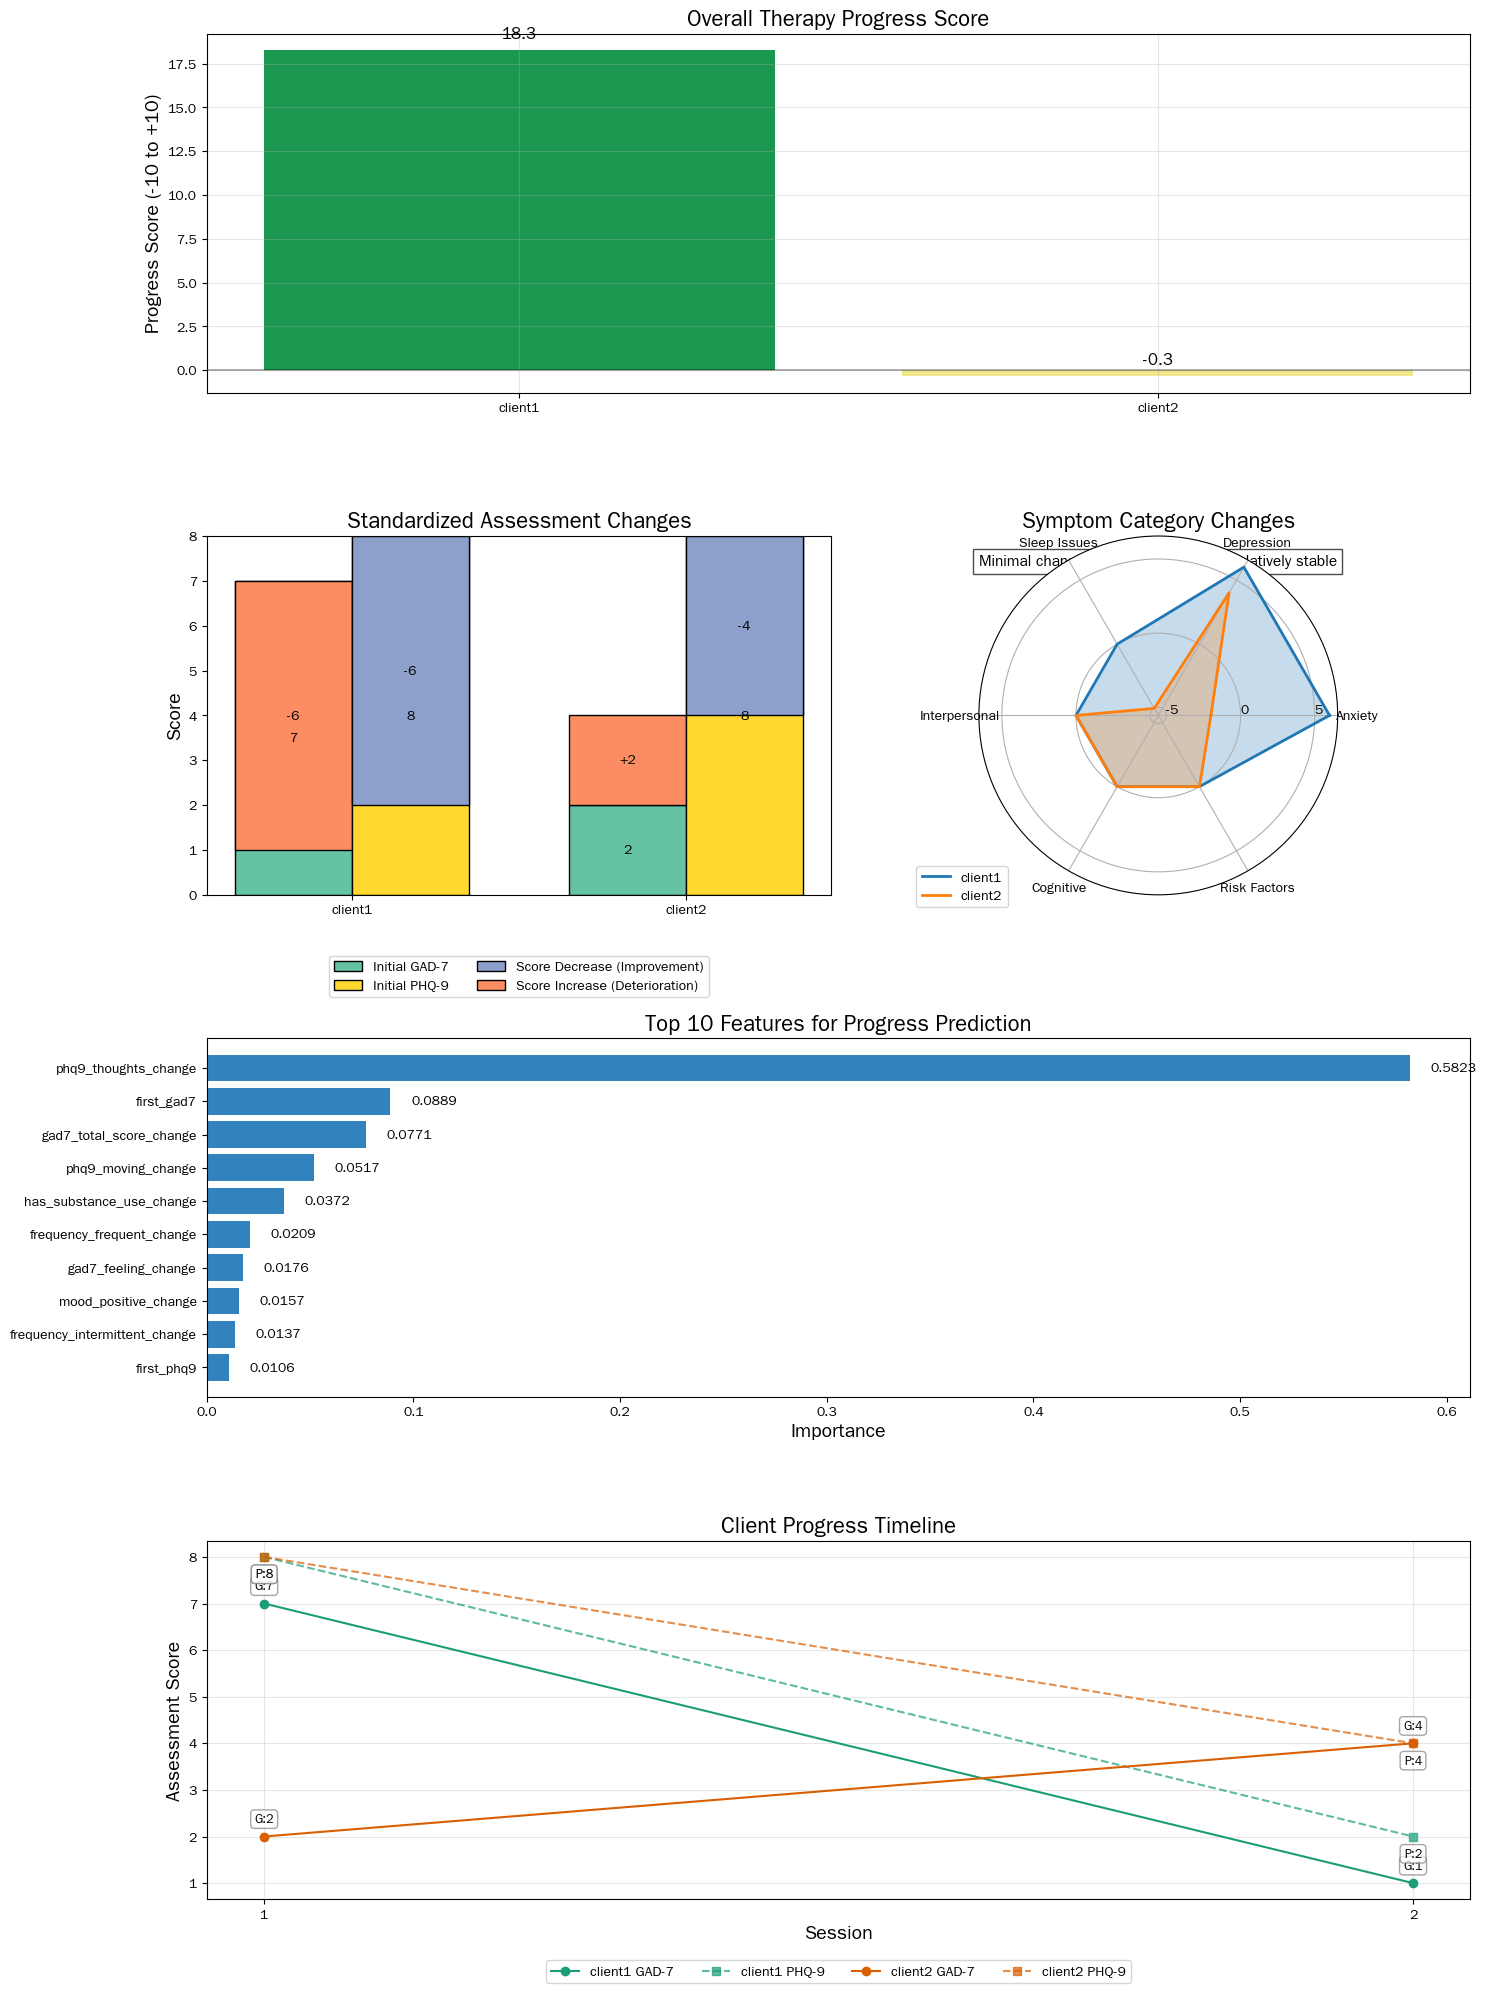

In [5]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import pickle
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# ----------------- 1. Data Preparation for Model Training -----------------

def prepare_model_training_data(client_progress_reports):
    """
    Prepare training data for the progress prediction model
    by creating synthetic data based on existing client reports
    """
    # Create a dataframe from our existing client data
    client_data = []
    
    # Extract features from our client progress reports
    for client_id, report in client_progress_reports.items():
        client_feature_dict = {}
        
        # Add base identifiers
        client_feature_dict['client_id'] = client_id
        client_feature_dict['progress_score'] = report['progress_score']
        
        # Add GAD-7 and PHQ-9 assessment scores
        client_feature_dict['first_gad7'] = report['standardized_assessments']['first_session']['gad7']
        client_feature_dict['last_gad7'] = report['standardized_assessments']['last_session']['gad7']
        client_feature_dict['first_phq9'] = report['standardized_assessments']['first_session']['phq9']
        client_feature_dict['last_phq9'] = report['standardized_assessments']['last_session']['phq9']
        
        # Extract change vectors
        change_vectors = report['symptom_changes']
        for key, value in change_vectors.items():
            if isinstance(value, (int, float)) and '_change' in key:
                client_feature_dict[key] = value
        
        client_data.append(client_feature_dict)
    
    # Convert to DataFrame
    df = pd.DataFrame(client_data)
    
    # Since we only have 2 clients, we'll generate synthetic data for model training
    # This is just for demonstration purposes - in production, you'd use real data
    synthetic_samples = 100
    synthetic_data = []
    
    for _ in range(synthetic_samples):
        # Create a synthetic sample by randomly sampling from our features
        # and applying small random variations
        sample = {}
        
        # Randomly select one of our clients as a base
        base_client = client_data[np.random.randint(0, len(client_data))]
        
        # Add features with slight variations
        for key, value in base_client.items():
            if key == 'client_id':
                sample[key] = f"synthetic_client_{_}"
            elif isinstance(value, (int, float)):
                # Add random variation
                if key == 'progress_score':
                    # Ensure progress score remains in a reasonable range
                    sample[key] = np.clip(value + np.random.normal(0, 2), -10, 10)
                else:
                    # For other numeric features, add smaller variations
                    variation = np.random.normal(0, abs(value) * 0.2) if value != 0 else np.random.normal(0, 0.5)
                    sample[key] = value + variation
            else:
                sample[key] = value
        
        # Make some coherent adjustments to maintain relationships between variables
        # If GAD-7 decreases, progress should generally improve
        gad7_change = sample['last_gad7'] - sample['first_gad7']
        phq9_change = sample['last_phq9'] - sample['first_phq9']
        
        # Adjust progress score based on GAD-7 and PHQ-9 changes (negative change is good)
        progress_adjustment = -(gad7_change + phq9_change) * 0.7
        sample['progress_score'] = np.clip(sample['progress_score'] + progress_adjustment, -10, 10)
        
        synthetic_data.append(sample)
    
    # Combine real and synthetic data
    all_data = client_data + synthetic_data
    full_df = pd.DataFrame(all_data)
    
    return full_df

# ----------------- 2. Therapy Progress Prediction Model -----------------

def build_progress_prediction_model(data_df):
    """
    Build and train a model to predict therapy progress scores
    """
    # Prepare feature matrix and target
    # Remove client_id and target variable
    X = data_df.drop(['client_id', 'progress_score'], axis=1, errors='ignore')
    y = data_df['progress_score']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models to try
    models = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42)
    }
    
    # Train and evaluate models
    model_results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        if name == 'RandomForest':
            param_grid = {
                'n_estimators': [50, 100],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5],
                'min_samples_leaf': [1, 2]
            }
        elif name == 'GradientBoosting':
            param_grid = {
                'n_estimators': [50, 100],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5],
                'min_samples_split': [2, 5]
            }
        else:  # XGBoost
            param_grid = {
                'n_estimators': [50, 100],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5],
                'subsample': [0.8, 1.0]
            }
        
        grid_search = GridSearchCV(
            model, param_grid, cv=5, scoring='neg_mean_squared_error'
        )
        grid_search.fit(X_train_scaled, y_train)
        
        # Get best model
        best_model = grid_search.best_estimator_
        
        # Make predictions
        y_pred = best_model.predict(X_test_scaled)
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        model_results[name] = {
            'model': best_model,
            'mse': mse,
            'mae': mae,
            'r2': r2,
            'best_params': grid_search.best_params_
        }
        
        print(f"{name} Results:")
        print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        print(f"Best Parameters: {grid_search.best_params_}")
        print("-" * 50)
    
    # Select best model based on R²
    best_model_name = max(model_results, key=lambda k: model_results[k]['r2'])
    best_model_info = model_results[best_model_name]
    
    print(f"\nSelected Model: {best_model_name}")
    print(f"MSE: {best_model_info['mse']:.4f}, MAE: {best_model_info['mae']:.4f}, R²: {best_model_info['r2']:.4f}")
    
    # Feature importance
    feature_importance = None
    if best_model_name == 'RandomForest':
        feature_importance = best_model_info['model'].feature_importances_
    elif best_model_name == 'GradientBoosting':
        feature_importance = best_model_info['model'].feature_importances_
    elif best_model_name == 'XGBoost':
        feature_importance = best_model_info['model'].feature_importances_
    
    if feature_importance is not None:
        features = X.columns
        importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
        importance_df = importance_df.sort_values('Importance', ascending=False)
        print("\nTop 10 Most Important Features:")
        print(importance_df.head(10))
    
    return {
        'best_model': best_model_info['model'],
        'best_model_name': best_model_name,
        'scaler': scaler,
        'feature_names': list(X.columns),
        'feature_importance': importance_df if feature_importance is not None else None,
        'metrics': {
            'mse': best_model_info['mse'],
            'mae': best_model_info['mae'],
            'r2': best_model_info['r2']
        }
    }

# ----------------- 3. Enhanced Visualization Framework -----------------

def create_enhanced_visualizations(client_progress_reports, model_info=None):
    """
    Create enhanced visualizations for therapy progress
    """
    plt.figure(figsize=(15, 20))
    gs = GridSpec(4, 2, figure=plt.gcf())
    
    # Visualization 1: Overall Progress Score
    ax1 = plt.subplot(gs[0, :])
    client_ids = list(client_progress_reports.keys())
    progress_scores = [report["progress_score"] for report in client_progress_reports.values()]
    
    # Create custom colormap for the progress scores
    colors = ['#d73027', '#f46d43', '#fdae61', '#fee08b', '#d9ef8b', '#a6d96a', '#66bd63', '#1a9850']
    cmap = LinearSegmentedColormap.from_list('progress_colors', colors)
    norm = plt.Normalize(-10, 10)
    
    bar_colors = [cmap(norm(score)) for score in progress_scores]
    
    bars = ax1.bar(client_ids, progress_scores, color=bar_colors)
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax1.set_title('Overall Therapy Progress Score', fontsize=16)
    ax1.set_ylabel('Progress Score (-10 to +10)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Add text labels on top of bars
    for bar, score in zip(bars, progress_scores):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{score:.1f}',
                 ha='center', va='bottom', fontsize=12)
    
    # Add interpretation text below each bar
    for i, client_id in enumerate(client_ids):
        interpretation = client_progress_reports[client_id]["progress_interpretation"]
        ax1.text(i, -10.5, interpretation, ha='center', va='top', 
                 fontsize=11, wrap=True, bbox=dict(facecolor='white', alpha=0.7))
    
    # Visualization 2: GAD-7 and PHQ-9 Score Changes
    ax2 = plt.subplot(gs[1, 0])
    
    # Prepare data for GAD-7 and PHQ-9 visualization
    assessment_data = []
    for client_id, report in client_progress_reports.items():
        first_gad7 = report["standardized_assessments"]["first_session"]["gad7"] 
        last_gad7 = report["standardized_assessments"]["last_session"]["gad7"]
        first_phq9 = report["standardized_assessments"]["first_session"]["phq9"]
        last_phq9 = report["standardized_assessments"]["last_session"]["phq9"]
        
        assessment_data.append({
            'client_id': client_id,
            'first_gad7': first_gad7,
            'last_gad7': last_gad7,
            'first_phq9': first_phq9,
            'last_phq9': last_phq9,
            'gad7_change': last_gad7 - first_gad7,
            'phq9_change': last_phq9 - first_phq9
        })
    
    assessment_df = pd.DataFrame(assessment_data)
    
    # Prepare for grouped bar chart
    clients = assessment_df['client_id']
    x = np.arange(len(clients))
    width = 0.35
    
    # GAD-7 bars
    gad7_bars = ax2.bar(x - width/2, assessment_df['first_gad7'], width, label='Initial GAD-7',
                         color='#66c2a5', edgecolor='black', linewidth=1)
    ax2.bar(x - width/2, assessment_df['gad7_change'], width,
            bottom=assessment_df['first_gad7'], color='#fc8d62' if any(assessment_df['gad7_change'] > 0) else '#8da0cb',
            edgecolor='black', linewidth=1)
    
    # PHQ-9 bars
    phq9_bars = ax2.bar(x + width/2, assessment_df['first_phq9'], width, label='Initial PHQ-9',
                         color='#ffd92f', edgecolor='black', linewidth=1)
    ax2.bar(x + width/2, assessment_df['phq9_change'], width,
            bottom=assessment_df['first_phq9'], color='#fc8d62' if any(assessment_df['phq9_change'] > 0) else '#8da0cb',
            edgecolor='black', linewidth=1)
    
    # Add labels and legend
    ax2.set_ylabel('Score', fontsize=14)
    ax2.set_title('Standardized Assessment Changes', fontsize=16)
    ax2.set_xticks(x)
    ax2.set_xticklabels(clients)
    
    # Create custom legend
    legend_elements = [
        mpatches.Patch(facecolor='#66c2a5', edgecolor='black', label='Initial GAD-7'),
        mpatches.Patch(facecolor='#ffd92f', edgecolor='black', label='Initial PHQ-9'),
        mpatches.Patch(facecolor='#8da0cb', edgecolor='black', label='Score Decrease (Improvement)'),
        mpatches.Patch(facecolor='#fc8d62', edgecolor='black', label='Score Increase (Deterioration)')
    ]
    ax2.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    
    # Add text annotations for the scores
    for i, client in enumerate(clients):
        # GAD-7 annotations
        first_gad7 = assessment_df['first_gad7'].iloc[i]
        last_gad7 = assessment_df['last_gad7'].iloc[i]
        ax2.text(i - width/2, first_gad7 / 2, f"{first_gad7:.0f}", 
                 ha='center', va='center', color='black', fontsize=10)
        ax2.text(i - width/2, first_gad7 + assessment_df['gad7_change'].iloc[i] / 2, 
                 f"{assessment_df['gad7_change'].iloc[i]:+.0f}", 
                 ha='center', va='center', color='black', fontsize=10)
        
        # PHQ-9 annotations
        first_phq9 = assessment_df['first_phq9'].iloc[i]
        last_phq9 = assessment_df['last_phq9'].iloc[i]
        ax2.text(i + width/2, first_phq9 / 2, f"{first_phq9:.0f}", 
                 ha='center', va='center', color='black', fontsize=10)
        ax2.text(i + width/2, first_phq9 + assessment_df['phq9_change'].iloc[i] / 2, 
                 f"{assessment_df['phq9_change'].iloc[i]:+.0f}", 
                 ha='center', va='center', color='black', fontsize=10)
    
    # Visualization 3: Radar Chart for Symptom Categories
    ax3 = plt.subplot(gs[1, 1], polar=True)
    
    # Define symptom categories
    categories = ['Anxiety', 'Depression', 'Sleep Issues', 'Interpersonal', 'Cognitive', 'Risk Factors']
    
    # Prepare data for radar chart
    radar_data = []
    for client_id, report in client_progress_reports.items():
        # Extract category-related metrics from report
        changes = report['symptom_changes']
        
        # Map metrics to categories
        category_scores = {
            'Anxiety': 0,
            'Depression': 0,
            'Sleep Issues': 0,
            'Interpersonal': 0,
            'Cognitive': 0,
            'Risk Factors': 0
        }
        
        # Anxiety indicators
        if 'gad7_total_score_change' in changes:
            category_scores['Anxiety'] = -changes['gad7_total_score_change'] # Negate so improvement is positive
        
        # Depression indicators
        if 'phq9_total_score_change' in changes:
            category_scores['Depression'] = -changes['phq9_total_score_change'] # Negate so improvement is positive
        
        # Sleep issues
        if 'has_sleep_issues_change' in changes:
            category_scores['Sleep Issues'] = -changes['has_sleep_issues_change'] * 5 # Negate so improvement is positive
        
        # Interpersonal factors
        interpersonal_keys = [k for k in changes.keys() if 'relationship' in k.lower() or 'social' in k.lower()]
        if interpersonal_keys:
            avg_score = np.mean([-changes[k] for k in interpersonal_keys]) # Negate so improvement is positive
            category_scores['Interpersonal'] = avg_score
        
        # Cognitive factors
        if 'cognitive_distortion_count_change' in changes:
            category_scores['Cognitive'] = -changes['cognitive_distortion_count_change'] * 2 # Negate so improvement is positive
        
        # Risk factors
        risk_keys = ['has_hopelessness_change', 'has_suicidal_thoughts_change']
        risk_values = [changes.get(k, 0) for k in risk_keys if k in changes]
        if risk_values:
            avg_risk = np.mean([-v * 5 for v in risk_values]) # Negate so improvement is positive
            category_scores['Risk Factors'] = avg_risk
        
        # Scale all values to be between -10 and 10
        for key in category_scores:
            category_scores[key] = np.clip(category_scores[key], -10, 10)
        
        # Create a row for this client
        values = [category_scores[cat] for cat in categories]
        radar_data.append({
            'client_id': client_id,
            'values': values
        })
    
    # Plot the radar chart
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1] # Close the loop
    
    # Add radial grid lines and labels
    ax3.set_rlabel_position(0)
    ax3.set_yticks([-10, -5, 0, 5, 10])
    ax3.set_yticklabels(['-10', '-5', '0', '5', '10'])
    ax3.grid(True)
    
    # Plot each client's data
    for i, data in enumerate(radar_data):
        values = data['values'] + data['values'][:1] # Close the loop
        ax3.plot(angles, values, linewidth=2, linestyle='solid', label=data['client_id'])
        ax3.fill(angles, values, alpha=0.25)
    
    # Set category labels
    ax3.set_xticks(angles[:-1])
    ax3.set_xticklabels(categories)
    
    # Add legend
    ax3.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    ax3.set_title('Symptom Category Changes', fontsize=16)
    
    # Visualization 4: Feature Importance from Model
    ax4 = plt.subplot(gs[2, :])
    
    if model_info and model_info.get('feature_importance') is not None:
        # Plot feature importance
        importance_df = model_info['feature_importance']
        top_features = importance_df.head(10)
        
        # Sort by importance
        top_features = top_features.sort_values('Importance')
        
        # Plot horizontal bar chart
        bars = ax4.barh(top_features['Feature'], top_features['Importance'], color='#3182bd')
        ax4.set_title('Top 10 Features for Progress Prediction', fontsize=16)
        ax4.set_xlabel('Importance', fontsize=14)
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                     f'{width:.4f}', ha='left', va='center', fontsize=10)
    else:
        ax4.text(0.5, 0.5, 'Model information not available', 
                 ha='center', va='center', fontsize=14)
        ax4.axis('off')
    
    # Visualization 5: Individual Client Progress Timeline
    ax5 = plt.subplot(gs[3, :])
    
    # Create a timeline visualization for each client
    client_colors = ['#1b9e77', '#d95f02', '#7570b3', '#e7298a']
    
    # Create x-axis with session numbers
    sessions = [1, 2]  # We currently have 2 sessions per client
    
    # For each client, plot GAD-7 and PHQ-9 scores across sessions
    for i, client_id in enumerate(client_ids):
        report = client_progress_reports[client_id]
        gad7_scores = [
            report["standardized_assessments"]["first_session"]["gad7"],
            report["standardized_assessments"]["last_session"]["gad7"]
        ]
        
        phq9_scores = [
            report["standardized_assessments"]["first_session"]["phq9"],
            report["standardized_assessments"]["last_session"]["phq9"]
        ]
        
        # Plot GAD-7 scores
        ax5.plot(sessions, gad7_scores, marker='o', linestyle='-', 
                 color=client_colors[i % len(client_colors)],
                 label=f'{client_id} GAD-7')
        
        # Plot PHQ-9 scores with dashed line
        ax5.plot(sessions, phq9_scores, marker='s', linestyle='--',
                 color=client_colors[i % len(client_colors)], 
                 alpha=0.7, label=f'{client_id} PHQ-9')
        
        # Add annotations
        for j, (gad7, phq9) in enumerate(zip(gad7_scores, phq9_scores)):
            ax5.annotate(f'G:{gad7}', (sessions[j], gad7), 
                        textcoords="offset points", xytext=(0,10), 
                        ha='center', fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))
            
            ax5.annotate(f'P:{phq9}', (sessions[j], phq9), 
                        textcoords="offset points", xytext=(0,-15), 
                        ha='center', fontsize=9,
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))
    
    # Set labels and title
    ax5.set_title('Client Progress Timeline', fontsize=16)
    ax5.set_xlabel('Session', fontsize=14)
    ax5.set_ylabel('Assessment Score', fontsize=14)
    ax5.set_xticks(sessions)
    ax5.grid(True, alpha=0.3)
    
    # Add legend
    ax5.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    # Adjust layout and spacing
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    
    # Save figure if needed
    plt.savefig('therapy_progress_dashboard.png', dpi=300, bbox_inches='tight')
    
    return plt

# ----------------- 4. Progress Prediction Function -----------------

def predict_client_progress(model_info, client_data):
    """
    Predict therapy progress for a client using the trained model
    
    Args:
        model_info: Dictionary with model, scaler, and feature names
        client_data: Dictionary with client features
        
    Returns:
        Dictionary with predicted progress score and interpretation
    """
    # Prepare input features
    feature_names = model_info['feature_names']
    
    # Ensure client data has all required features
    input_features = []
    for feature in feature_names:
        if feature in client_data:
            input_features.append(client_data[feature])
        else:
            # If feature is missing, use 0 as default
            input_features.append(0)
    
    # Convert to numpy array and reshape
    input_array = np.array(input_features).reshape(1, -1)
    
    # Scale features
    scaled_input = model_info['scaler'].transform(input_array)
    
    # Make prediction
    predicted_score = model_info['best_model'].predict(scaled_input)[0]
    
    # Interpret score
    interpretation = interpret_progress_score(predicted_score)
    
    return {
        'predicted_progress_score': predicted_score,
        'interpretation': interpretation,
        'model_used': model_info['best_model_name']
    }

# ----------------- 5. Complete Therapy Progress Framework -----------------

def create_therapy_progress_framework():
    """
    Create and demonstrate the complete therapy progress framework
    """
    print("===== THERAPY PROGRESS TRACKING FRAMEWORK =====")
    
    # 1. Prepare model training data
    print("\n1. Preparing model training data...")
    training_data = prepare_model_training_data(client_progress_reports)
    print(f"Generated dataset with {len(training_data)} samples")
    
    # 2. Build and train the progress prediction model
    print("\n2. Building progress prediction model...")
    model_info = build_progress_prediction_model(training_data)
    
    # 3. Create enhanced visualizations
    print("\n3. Creating enhanced visualizations...")
    _ = create_enhanced_visualizations(client_progress_reports, model_info)
    print("Enhanced visualizations created and saved as 'therapy_progress_dashboard.png'")
    
    # 4. Demonstrate progress prediction for a new client
    print("\n4. Demonstrating progress prediction for a new client...")
    
    # Create sample data for a new client
    new_client_data = {
        'first_gad7': 12,  # Starting with moderate anxiety
        'last_gad7': 8,    # Some improvement in anxiety
        'first_phq9': 14,  # Starting with moderate depression
        'last_phq9': 10,   # Some improvement in depression
        'gad7_total_score_change': -4,
        'phq9_total_score_change': -4,
        'avg_symptom_intensity_change': -1.0,
        'mood_positive_change': 1,
        'mood_negative_change': -1,
        'has_sleep_issues_change': -1
    }
    
    prediction_result = predict_client_progress(model_info, new_client_data)
    
    print(f"Predicted Progress Score: {prediction_result['predicted_progress_score']:.2f}")
    print(f"Interpretation: {prediction_result['interpretation']}")
    print(f"Model Used: {prediction_result['model_used']}")
    
    # 5. Save model for future use
    print("\n5. Saving model for future use...")
    model_output = {
        'model': model_info['best_model'],
        'scaler': model_info['scaler'],
        'feature_names': model_info['feature_names'],
        'model_name': model_info['best_model_name']
    }
    
    with open('therapy_progress_model.pkl', 'wb') as f:
        pickle.dump(model_output, f)
    
    print("Model saved as 'therapy_progress_model.pkl'")
    
    print("\n===== FRAMEWORK CREATION COMPLETE =====")
    return {
        'model_info': model_info,
        'visualizations': 'therapy_progress_dashboard.png',
        'model_file': 'therapy_progress_model.pkl',
        'training_data_size': len(training_data)
    }

# Execute the framework creation
framework_info = create_therapy_progress_framework()

# Provide a summary of the framework components
print("\n===== FRAMEWORK SUMMARY =====")
print(f"1. Model Performance: R² = {framework_info['model_info']['metrics']['r2']:.4f}")
print(f"2. Training Data Size: {framework_info['training_data_size']} samples")
print(f"3. Model Type: {framework_info['model_info']['best_model_name']}")
print(f"4. Visualizations: {framework_info['visualizations']}")
print(f"5. Saved Model: {framework_info['model_file']}")